#### Librerías

In [1]:
from transformers import pipeline
import requests
import os
import base64
import pandas as pd
from groq import Groq
from pydub import AudioSegment
from sklearn.cluster import KMeans
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import re
from datetime import timedelta
import os
import soundfile as sf
import librosa
import numpy as np
from jiwer import wer, cer
import altair as alt
import difflib
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import time
from typing import Optional, Annotated, Dict, Any
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
import math

#### Ruta y variables de entorno

In [2]:
#Usamos la variable de entorno GROQ_API_KEY y rutas para almacenar los datos:
client = Groq()
filename = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/audio/audio_full.m4a"
ruta_transcript = '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/transcript/'
ruta_transcript_gold = '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/transcript_gold/'
ruta_transcript_gold_best5 = '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/transcript_gold/'
base_path = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold"
metric_path = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/metrics/"
insights_path = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/insights/"
graph_path = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/graph/"
ruta_pronunciation_feedback = '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/feedback/'
OUTPUT_DIR = "/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold"
CLIP_MIN_MS = 30_000  #30 seg
CLIP_MAX_MS = 60_000  #60 seg

### Implementación de sistema multiagente con LangGraph
- Se integró LangGraph para orquestar tareas como transcripción, corrección y evaluación en procesos paralelos y modulares.
- Esto mejora la eficiencia, escalabilidad y trazabilidad, facilitando futuras extensiones del pipeline.
- Se explicará el código utilizado y el analisis del resultado en cada nodo.
- Como buena práctica trabajaremos con una estructura por carpeta para garantizar que los resultados/código se guarden correctamente.
- Audio input tiene un formato .m4a con 5 min de duración

In [3]:
def ms_to_time(ms):
    seconds = ms // 1000
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return f"{h:02}:{m:02}:{s:02}"

In [4]:
def detectar_problemas_pronunciacion(raw, gold):
    raw_words = raw.lower().split()
    gold_words = gold.lower().split()

    # Detectar diferencias
    sm = difflib.SequenceMatcher(None, gold_words, raw_words)
    errores = []
    for opcode in sm.get_opcodes():
        if opcode[0] in ['replace', 'delete']:
            errores.extend(gold_words[opcode[1]:opcode[2]])
    
    return list(set(errores))

#### LangGraph

In [9]:
class GraphState(BaseModel):
    graph_state: Optional[str] = ""
    #graph_state: Annotated[Optional[list[str]], "aggregate"] = []

    transcript_raw: Optional[list[Dict]] = []
    gold_set_dividir_clips: Optional[list[Dict]] = []
    gold_set_all_audio_transcribir: Optional[list[Dict]] = []
    gold_set_transcribir_clasificacion: Optional[list[Dict]] = []
    selected_ids: Optional[list[Dict]] = []
    corregir_transcripcion_audio: Optional[list[Dict]] = []
    evaluacion_metrica: Optional[list[Dict]] = []
    insight_pedagogico: Optional[str] = ""
    feedback_pronunciacion_audio: Optional[list[Dict]] = []

def greeting_node(state):
    #Este nodo no modifica nada, solo pasa el estado
    return {}

def peticion_node(state):
    #Solo modificamos graph_state como Inicio
    return {"graph_state": state}

def transcriber(state):
    print("============>START: Primer ejercicio: Transcribiendo audio")

    """Comentarios: Utilizamos los modelos Groq(diponible modelos como Wishper o llamaLLM) para transcribir el audio completo.
        whisper-large-v3 cumple los requisitos del problema, se valido con whisper-large-v3-turbo obteniendo resultados similares.
        El archivo base es un '.m4a' con una duración de 5 min"""
    
    with open(filename, "rb") as file:
        translation = client.audio.translations.create(
            file=(os.path.basename(filename), file.read()),
            model="whisper-large-v3", #whisper-large-v3-turbo
            prompt=None,        
            response_format="json",
            temperature=0.0
        )

        transcript_text = translation.text
        print("Transcripción completada:\n", transcript_text)

        transcript_raw_data = [{
            "audio_id": "01",
            "transcript_raw": transcript_text
        }]
        df_transcript_raw = pd.DataFrame(transcript_raw_data)
        df_transcript_raw.to_csv(f"{ruta_transcript}transcript_raw.csv", index=False, encoding="utf-8")
        print("Transcripción guardada como transcript_raw.csv")
    
    print("============>END: Primer ejercicio: Transcribiendo audio")
    return {"transcript_raw": transcript_raw_data}
    #return {"graph_state": "Transcripción completa.", "transcript_raw": transcript_raw_data}

def gold_set_dividir(state):

    print("============>START: Segundo ejercicio - Dividir audios, transcibir e identificar los mejores audios (solo 5 segmentos)")

    """Comentarios: El audio base de 5 minutos se divide en segmentos de 30 segundos (10 archivos en total).
        Este procedimiento en lugar de hacerlo manual como indicaba el problema, se realiza de forma automática.
        Como primer paso, se divide el audio completo en segmentos de 30 segundos, luego se transcriben y clasifican automáticamente
         a través de una LLM(Llama).Toto archivo se guarda en la carpeta data"""
    
    #===>PAS 1: Cargar y dividir audio completo en fragmentos
    full_audio = AudioSegment.from_file(filename, format="m4a")
    step_ms = 30_000  #cort de los archivos (30 seg)
    clips = []
    start = 0
    while start < len(full_audio):
        end = min(start + step_ms, len(full_audio))
        clip = full_audio[start:end]
        if CLIP_MIN_MS <= len(clip) <= CLIP_MAX_MS:
            clips.append((clip, start, end))
        start += step_ms
        if len(clips) == 10:
            break
    
    #Guardamos los archivos de audio en la carpeta OUTPUT_DIR:
    clip_info = []
    for i, (clip, start_ms, end_ms) in enumerate(clips, 1):
        clip_name = f"clip_{i:02}.m4a"
        clip_path = os.path.join(OUTPUT_DIR, clip_name)
        clip.export(clip_path, format="mp4", codec="aac")
        clip_info.append({
            "clip_id": f"{i:02}",
            "file_path": clip_path,
            "start_time": ms_to_time(start_ms),
            "end_time": ms_to_time(end_ms)
        })

    
    print(clip_info)
    print("============>END: Segundo ejercicio - Dividir audios, transcibir e identificar los mejores audios (solo 5 segmentos)")
    return {"gold_set_dividir_clips": clip_info}
    #return {"graph_state": "División completa.", "gold_set_dividir_clips": clip_info}

def gold_set_traduccion_clasificacion(state):
    print("============>START: Parte final del segundo ejercicio - transcibir todo los audios y clasificar automáticamente")

    """Comentarios: 
        Como parte final de la segunda parte, una vez generado los archivos, luego se transcriben y clasifican automáticamente
         a través de una LLM(Llama).Toto archivo se guarda en la carpeta data"""
    
    clip_info = state.gold_set_dividir_clips

    #====>Transcripción y clasificación automática:
    client = Groq()
    rows = []
    for info in clip_info:
        #Transcripción
        with open(info["file_path"], "rb") as f:
            response = client.audio.transcriptions.create(
                file=(os.path.basename(info["file_path"]), f.read()),
                model="whisper-large-v3"
            )
        text = response.text

        #Clasificación con LLM:
        with open('/Users/rayespinoza/AI_Projects/speach_text_ai_project/service/prompt/prompt_t_s.txt', 'r', encoding='utf-8') as file: 
            PROMPT_TEMPLATE_T_S = file.read()

            prompt = PROMPT_TEMPLATE_T_S.format(
                context=text)

        chat_response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[{"role": "user", "content": prompt}]
        )
        speaker = chat_response.choices[0].message.content.strip().lower()
        #if speaker not in ["teacher", "student"]:
        #    speaker = "unknown"

        #Registro===>
        rows.append({
            "clip_id": info["clip_id"],
            "start_time": info["start_time"],
            "end_time": info["end_time"],
            "transcript_gold": text,
            "speaker": speaker
        })
    df = pd.DataFrame(rows)
    df.to_csv(f"{ruta_transcript_gold}transcript_gold.csv", index=False, encoding="utf-8")
    print("transcript_gold.csv generado exitosamente")
    print("============>END: Parte final del segundo ejercicio - transcibir todo los audios y clasificar automáticamente")
    return {"gold_set_all_audio_transcribir": rows}

def gold_set_5_mejores(state):

    print("============>START: Parte final del segundo ejercicio - Elegir los mejores 5 segmentos - audio")
    df_ls = state.gold_set_all_audio_transcribir
    df = pd.DataFrame(df_ls)
    print(df)
    #====>Encontramos los mejores 5 segmentos - audio:
    with open('/Users/rayespinoza/AI_Projects/speach_text_ai_project/service/prompt/prompt_best_segment.txt', 'r', encoding='utf-8') as file: 
            PROMPT_TEMPLATE_SEGMENT = file.read()

    segmentos_texto = ""
    for _, row in df.iterrows():
        segmentos_texto += f"Clip {row['clip_id']}: {row['transcript_gold']}\n"

    print(segmentos_texto)
    prompt = PROMPT_TEMPLATE_SEGMENT.format(
                context=segmentos_texto.strip())

    client = Groq()
    #Usaremos nuestro modelo LLM para decidir los mejores segmentos:
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}]
    )

    #Extraer IDs:
    ids_text = response.choices[0].message.content.strip()
    selected_ids = [x.strip().zfill(2) for x in ids_text.split(",") if x.strip().isdigit()]
    gold_df = df[df["clip_id"].isin(selected_ids)].copy()
    gold_df_ls = gold_df.to_dict(orient="records")

    print(selected_ids)
    gold_df.to_csv(f"{ruta_transcript_gold}transcript_gold_best5.csv", index=False, encoding="utf-8")
    print("transcript_gold_best5.csv generado exitosamente")

    print("============>END: Parte final del segundo ejercicio - Elegir los mejores 5 segmentos - audio")
    return {"selected_ids":selected_ids ,"gold_set_transcribir_clasificacion": gold_df_ls}
    #return {"graph_state": "transcibir, clasificación completa y mejores 5","selected_ids":selected_ids ,"gold_set_transcribir_clasificacion": gold_df_ls}

def corregir_transcripcion(state):
    print("Pipeline de corrección: Corregir la transcripcción: de transcript_raw → transcript_corrected--->Ejercicio 3")

    """Comentarios: 
        Como parte del desarrollo utilizarmos llama-3.1-8b-instant, un modelo de LLM que permite corregir la transcripción de forma eficiente,
        además ara esta prueba técnica usaremos el modelo solo en inference. No aplicaremos fine-tuning porque no tenemos ejemples para reentrenamiento robusta.
        LLMs como LLaMA funcionan bien con prompts adecuados
        Justificación técnica:
        Modelo: llama-3.1-8b-instant
        Tamaño:  aprox. 8 mil millones de parámetros
        Uso: Solo inference (zero-shot), sin fine-tuning.
        Justificación: Este modelo ofrece una buena combinación de velocidad y calidad para la interpretación de los texts de audio"""
    
    df_transcript_raw = pd.DataFrame(state.transcript_raw)
    corrected = []
    with open('/Users/rayespinoza/AI_Projects/speach_text_ai_project/service/prompt/prompt_corrected.txt', 'r', encoding='utf-8') as file: 
            PROMPT_TEMPLATE_CORRECTED = file.read()

    full_transcript_raw_text = " ".join(df_transcript_raw["transcript_raw"].tolist())

    prompt = PROMPT_TEMPLATE_CORRECTED.format(
                context=full_transcript_raw_text)
    
    response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[{"role": "user", "content": prompt}]
        )

    corrected_text = response.choices[0].message.content.strip()
    corrected.append(corrected_text)

    df_transcript_raw["transcript_corrected"] = corrected
    transcript_corrected_data_ls = df_transcript_raw.to_dict(orient="records")
    #===>Guardar resultado:
    df_transcript_raw.to_csv(f"{ruta_transcript}transcript_corrected.csv", index=False,encoding="utf-8")
    
    print("Corrección de transcripción completada")
    return {"corregir_transcripcion_audio": transcript_corrected_data_ls}
    #return {"graph_state": "Corrección de transcripción", "corregir_transcripcion_audio": transcript_corrected_data_ls}

def metricas_visualizacion(state):
    print("Para los 5 clips gold: Calcula WER y CER **raw vs. gold** y **corrected vs. gold**--->Ejercicio 4")

    """Comentarios: 
        Para generar las metricas y tener una visualización de las mejoras en la transcripción, primero es necesario 
        obtener los clips de audio y sus transcripciones originales de los 5 mejores segmentos (Gold set), es decir utilizaremos los 5 mejores audios
        seleccionados por la llma ('01', '03', '04', '05', '09' - puede variar por que el modelo no es determinista) y generamos sus respectivas
        transcripciones y correcciones. Esto garantiza que las métricas se calculen sobre los mismos segmentos de audio y tener una metricas más acidas."""
    
    #====>Primer paso, obtenemos las transcripciones de los mejores clips:
    clip_ids = state.selected_ids
    results = []
    for clip_id in clip_ids:
        filename = os.path.join(base_path, f"clip_{clip_id}.m4a")
        with open(filename, "rb") as file:
            response = client.audio.translations.create(
                file=(f"clip_{clip_id}.m4a", file.read()),
                model="whisper-large-v3",
                temperature=0.0,
                response_format="json"
            )
            results.append({
                "clip_id": clip_id,
                "transcript_raw": response.text.strip()
            })

    df_raw_clips = pd.DataFrame(results)
    df_raw_clips.to_csv(f"{metric_path}transcript_raw_metric.csv", index=False)

    #====>Segundp paso, corregimos las transcripciones obtenidas:
    corrected = []
    with open('/Users/rayespinoza/AI_Projects/speach_text_ai_project/service/prompt/prompt_corrected.txt', 'r', encoding='utf-8') as file: 
            PROMPT_TEMPLATE_CORRECTED = file.read()

    for i, row in df_raw_clips.iterrows():
        filled_prompt = PROMPT_TEMPLATE_CORRECTED.format(context=row["transcript_raw"])
        
        response = client.chat.completions.create(
            model="llama-3.1-8b-instant",
            messages=[{"role": "user", "content": filled_prompt}]
        )

        corrected_text = response.choices[0].message.content.strip()
        corrected.append(corrected_text)

    df_raw_clips["transcript_corrected"] = corrected
    df_raw_clips.to_csv(f"{metric_path}transcript_raw_metric_corrected.csv", index=False)

    #====>Tercer paso, realizamos el merge y calculamos las métricas WER y CER:
    gold_ls=state.gold_set_transcribir_clasificacion
    gold_df = pd.DataFrame(gold_ls)
    eval_df = gold_df.merge(df_raw_clips, on="clip_id")
    eval_df["WER_raw"] = eval_df.apply(lambda row: wer(row["transcript_gold"], row["transcript_raw"]), axis=1)
    eval_df["WER_corrected"] = eval_df.apply(lambda row: wer(row["transcript_gold"], row["transcript_corrected"]), axis=1)
    eval_df["CER_raw"] = eval_df.apply(lambda row: cer(row["transcript_gold"], row["transcript_raw"]), axis=1)
    eval_df["CER_corrected"] = eval_df.apply(lambda row: cer(row["transcript_gold"], row["transcript_corrected"]), axis=1)

    eval_df["WER_improvement_%"] = 100 * (eval_df["WER_raw"] - eval_df["WER_corrected"]) / eval_df["WER_raw"]
    eval_df["CER_improvement_%"] = 100 * (eval_df["CER_raw"] - eval_df["CER_corrected"]) / eval_df["CER_raw"]

    eval_df.to_csv(f"{metric_path}transcription_eval_final.csv", index=False)
    eval_df_ls= eval_df.to_dict(orient="records")

    #====>Visualización de las métricas:
    df = eval_df
    df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)

    #Preparar datos en formato "long":
    df_long = df[["clip_id", "WER_improvement_%", "CER_improvement_%"]].melt(
        id_vars="clip_id",
        var_name="Metric",
        value_name="Improvement"
    )
    df_long["Improvement"] = df_long["Improvement"].clip(lower=-100, upper=100)

    #Crear gráfico de barras agrupadas:
    chart = alt.Chart(df_long).mark_bar().encode(
        x=alt.X('clip_id:N', title='Clip ID'),
        y=alt.Y('Improvement:Q', title='Mejora porcentual (%)'),
        color=alt.Color('Metric:N', title='Métrica'),
        column=alt.Column('Metric:N', title=None)
    ).properties(
        title="Mejora porcentual en WER y CER por fragmento",
        width=150,
        height=300
    ).configure_axis(
        labelFontSize=12,
        titleFontSize=14
    ).configure_title(
        fontSize=16,
        anchor='start'
    )
    #Guardar como HTML:
    chart.save(f"{graph_path}altair_wer_cer_improvement.html")
    
    print("Métricas y visualización completadas")
    return {"evaluacion_metrica": eval_df_ls}

def insights_pedagogicos(state):
    print("Basándote en los errores detectados en esos 5 clips, extrae los **3–5 errores gramaticales o léxicos** más frecuentes de los estudiantes--->Ejercicio 5")

    """Comentarios: 
        Para completar este ejercicio, utilizaremos los clips de audio y sus transcripciones originales de los 5 mejores segmentos (Gold set), llm llama-3.1-8b-instant y 
        prompt preparado para obtener los insights pedagógicos con reglas de negocio relacionadas a la pronunciación y errores comunes."""
    
    eval_ls = state.evaluacion_metrica
    eval_df = pd.DataFrame(eval_ls)
    #===>Filtramos solo los estudiantes:
    student_clips = eval_df[eval_df["speaker"] == "student"].copy()
    
    correcciones = []
    for i, row in student_clips.iterrows():
        raw = row["transcript_raw"]
        corrected = row["transcript_corrected"]
        correcciones.append(f"- Original: {raw}\n  Corregido: {corrected}")

    contexto = "\n\n".join(correcciones)

    #===>Prompt
    with open("/Users/rayespinoza/AI_Projects/speach_text_ai_project/service/prompt/prompt_Insights.txt", "r", encoding="utf-8") as f:
        prompt_template = f.read()

    prompt = prompt_template.replace("{context}", contexto)

    #===>Modelo
    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[{"role": "user", "content": prompt}]
    )

    #Respuesta
    print("Insights pedagógicos:\n")
    print(response.choices[0].message.content.strip())
    respuesta = response.choices[0].message.content.strip()
    output_path = f"{insights_path}pedagogical_insights.txt"
    with open(output_path, "w", encoding="utf-8") as f:
        f.write(respuesta)

    print(f"Insight guardado correctamente en: {output_path}")
        
    return {"insight_pedagogico": respuesta}
    #return {"graph_state": "insight pedagogico completa.", "insight_pedagogico": respuesta}

def feedback_pronunciacion(state):
    print("Como valor agregado aplicaremos el feedback de pronunciación-->Ejercicio 6")

    """Comentarios: 
        Para ejecutar este ejercicio, utilizaremos los clips de audio y sus transcripciones originales de los 5 mejores segmentos (transcript_gold, transcript_raw y transcript_corrected),
        llm llama-3.1-8b-instant y una función para obtener el feedback de pronunciación"""
    
    eval_ls = state.evaluacion_metrica
    eval_df = pd.DataFrame(eval_ls)
    #Aplicamos el feedback de pronunciación:
    feedback = []
    for _, row in eval_df.iterrows():
        palabras_dudosas = detectar_problemas_pronunciacion(row["transcript_raw"], row["transcript_gold"])
        feedback.append(", ".join(palabras_dudosas) if palabras_dudosas else "No issues")

    eval_df["pronunciation_feedback"] = feedback
    eval_df_ls= eval_df.to_dict(orient="records")

    eval_df.to_csv(f"{ruta_pronunciation_feedback}pronunciation_feedback.csv", index=False, encoding="utf-8")
    print("pronunciation_feedback.csv generado exitosamente")

    print("Feedback de pronunciación completado")
    return {"feedback_pronunciacion_audio": eval_df_ls}
    #return {"graph_state": "Feedback de pronunciación completa.", "feedback_pronunciacion_audio": eval_df_ls}

In [10]:
#Creamos el grafo de estados
graph = StateGraph(GraphState)

#Definimos los nodos del grafo
graph.add_node("greeting_node" ,greeting_node)
graph.add_node("peticion_node", peticion_node)
graph.add_node("transcriber", transcriber)
graph.add_node("gold_set_dividir", gold_set_dividir)
graph.add_node("gold_set_traduccion_clasificacion", gold_set_traduccion_clasificacion)
graph.add_node("gold_set_5_mejores", gold_set_5_mejores)
graph.add_node("corregir_transcripcion", corregir_transcripcion)
graph.add_node("metricas_visualizacion", metricas_visualizacion)
graph.add_node("insights_pedagogicos", insights_pedagogicos)
graph.add_node("feedback_pronunciacion", feedback_pronunciacion)

#Generamos los enlaces entre los nodos
graph.add_edge(START, "greeting_node")
graph.add_edge("greeting_node", "peticion_node")
graph.add_edge("peticion_node", "transcriber")
graph.add_edge("peticion_node", "gold_set_dividir")
graph.add_edge("gold_set_dividir", "gold_set_traduccion_clasificacion")
graph.add_edge("gold_set_traduccion_clasificacion", "gold_set_5_mejores")
graph.add_edge("gold_set_5_mejores", "corregir_transcripcion")
graph.add_edge("corregir_transcripcion", "metricas_visualizacion")
graph.add_edge("metricas_visualizacion", "insights_pedagogicos")
#graph.add_edge("corregir_transcripcion", "insights_pedagogicos")
#graph.add_edge("corregir_transcripcion", "metricas_visualizacion")
#graph.add_edge("metricas_visualizacion", "feedback_pronunciacion")
graph.add_edge("insights_pedagogicos", "feedback_pronunciacion")

#graph.add_edge("metricas_visualizacion", "insights_pedagogicos")
#graph.add_edge("insights_pedagogicos", "feedback_pronunciacion")
graph.add_edge("transcriber", END)
graph.add_edge("feedback_pronunciacion", END)

#Compilar el grafo
graph_compiled = graph.compile()

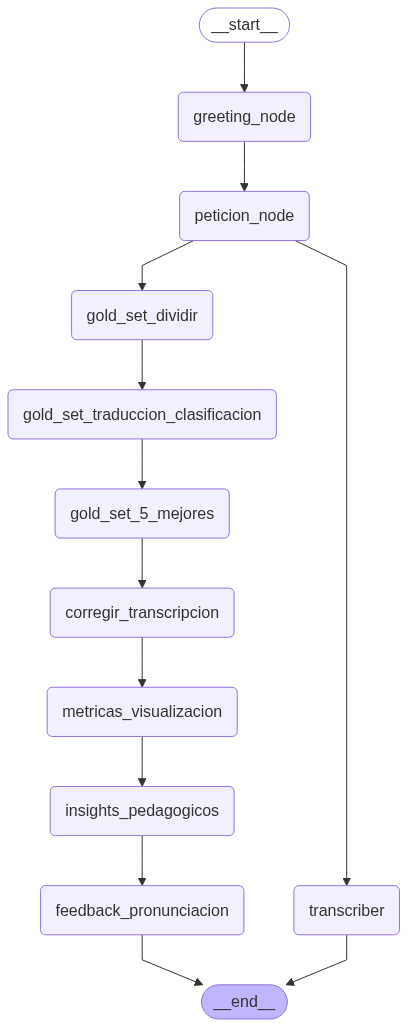

In [11]:
from IPython.display import Image, display

graph_compiled = graph.compile()

try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
base_dict = {"graph_state": "Inicio del proceso"}
resp = graph_compiled.invoke(base_dict)
print(resp)

============>START: Segundo ejercicio - Dividir audios, transcibir e identificar los mejores audios (solo 5 segmentos)============>START: Primer ejercicio: Transcribiendo audio

[{'clip_id': '01', 'file_path': '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold/clip_01.m4a', 'start_time': '00:00:00', 'end_time': '00:00:30'}, {'clip_id': '02', 'file_path': '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold/clip_02.m4a', 'start_time': '00:00:30', 'end_time': '00:01:00'}, {'clip_id': '03', 'file_path': '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold/clip_03.m4a', 'start_time': '00:01:00', 'end_time': '00:01:30'}, {'clip_id': '04', 'file_path': '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold/clip_04.m4a', 'start_time': '00:01:30', 'end_time': '00:02:00'}, {'clip_id': '05', 'file_path': '/Users/rayespinoza/AI_Projects/speach_text_ai_project/data/clips_gold/clip_05.m4a', 'start_time': '00:02:00', 'end_time':